# 2 Groupify

### Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

### 2.1.1 Getting your data + feature engineering
1.Access to the data found in this dataset

**Importing all the useful libraries to perform the tasks**

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
import findspark
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import random
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
dataset = pd.read_csv('vodclickstream_uk_movies_03.csv')

### 2.1.2
Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

a) Favorite genre (i.e., the genre on which the user spent the most time)

b) Average click duration

c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

e) Average time spent a day by the user (considering only the days he logs in)

So, in the end, you should have for each user_id five features.

In [3]:
# We analyze for each column if there are none values
(dataset['user_id']=='').sum()

0

There aren't any none values in the dataset  

#### Now let's analyze the `genres`

In [4]:
#we're making the genres column as genres lists
dataset.genres.apply(lambda row: row.split(','))

0                                [Comedy,  Drama,  Romance]
1                   [Fantasy,  Horror,  Mystery,  Thriller]
2                                       [Action,  Thriller]
3                                          [Action,  Drama]
4         [Animation,  Action,  Adventure,  Comedy,  Fam...
                                ...                        
671731                                          [Talk-Show]
671732    [Animation,  Action,  Adventure,  Family,  Sci...
671733                        [Action,  Adventure,  Sci-Fi]
671734                                [Documentary,  Music]
671735                                     [Comedy,  Drama]
Name: genres, Length: 671736, dtype: object

In [5]:
(dataset['genres'] == 'NOT AVAILABLE').sum()

26561

In [6]:
dataset = dataset[dataset['genres'] != 'NOT AVAILABLE']

Create a new column called `genres_list`

In [7]:
dataset['genres_list']=''

In [8]:
dataset['genres_list']=dataset.genres.apply(lambda row: [word.strip() for word in row.split(',')]) #escludo gli extra space con strip

In [9]:
#unique values
unique_genres = set()
dataset['genres_list'].apply(lambda row: [unique_genres.add(value) for value in row])

0                           [None, None, None]
1                     [None, None, None, None]
2                                 [None, None]
3                                 [None, None]
4         [None, None, None, None, None, None]
                          ...                 
671731                                  [None]
671732          [None, None, None, None, None]
671733                      [None, None, None]
671734                            [None, None]
671735                            [None, None]
Name: genres_list, Length: 645175, dtype: object

In [10]:
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [11]:
(dataset['duration'] < 0 ).sum()

20931

In [12]:
dataset = dataset[dataset['duration'] >=0]

##### First feature: Favorite genres

In [13]:
dataset_feature_1 = dataset[['user_id', 'duration', 'genres_list']].copy()
dataset_feature_1 = dataset_feature_1.explode('genres_list')
dataset_feature_1=dataset_feature_1.groupby(['user_id', 'genres_list'])['duration'].sum().reset_index()
max_duration_genres=dataset_feature_1.loc[dataset_feature_1.groupby('user_id')['duration'].idxmax()]
dataset_user = max_duration_genres.assign(fav_genre=max_duration_genres['genres_list'])[['user_id', 'fav_genre']]
dataset_user.reset_index(drop=True, inplace=True)
dataset_user


,user_id,fav_genre
0,00004e2862,Crime
1,000052a0a0,Action
2,000090e7c8,Mystery
3,000118a755,Horror
4,000296842d,Drama
...,...,...
150958,fffd9bf758,Crime
150959,fffe7b777b,Drama
150960,fffeac83be,Drama
150961,ffff2c5f9e,Action


##### Second feature: Average click duration

In [14]:
dataset_feature_2=dataset[['user_id','duration']].copy()
dataset_feature_2=dataset_feature_2.groupby('user_id').duration.mean().reset_index()
dataset_feature_2 = dataset_feature_2.assign(duration_average=dataset_feature_2['duration'])[['user_id', 'duration_average']]
dataset_user = pd.merge(dataset_user, dataset_feature_2, on='user_id')
dataset_user

,user_id,fav_genre,duration_average
0,00004e2862,Crime,0.000000
1,000052a0a0,Action,2024.166667
2,000090e7c8,Mystery,0.000000
3,000118a755,Horror,0.000000
4,000296842d,Drama,11044.000000
...,...,...,...
150958,fffd9bf758,Crime,8495.000000
150959,fffe7b777b,Drama,1785.000000
150960,fffeac83be,Drama,40606.272727
150961,ffff2c5f9e,Action,0.000000


##### Third feature: The most spent time during a day

In [15]:
dataset_feature_3=dataset[['user_id','duration', 'datetime']].copy()
dataset_feature_3.datetime = pd.to_datetime(dataset_feature_3.datetime)

def categorize_time_of_day(hour):
    if 6 <= hour < 15:
        return 'Morning'
    elif 15 <= hour < 21:
        return 'Afternoon'
    else:
        return 'Night'

dataset_feature_3['time_of_day'] = dataset_feature_3.datetime.dt.hour.apply(categorize_time_of_day)
dataset_feature_3=dataset_feature_3.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()
dataset_feature_3=dataset_feature_3.sort_values(by=['user_id', 'duration'], ascending=[True, False])
dataset_feature_3=dataset_feature_3.drop_duplicates(subset=['user_id'])
dataset_feature_3 = dataset_feature_3.assign(preferred_time_of_day=dataset_feature_3['time_of_day'])[['user_id', 'preferred_time_of_day']]
dataset_user = pd.merge(dataset_user, dataset_feature_3, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day
0,00004e2862,Crime,0.000000,Afternoon
1,000052a0a0,Action,2024.166667,Afternoon
2,000090e7c8,Mystery,0.000000,Afternoon
3,000118a755,Horror,0.000000,Night
4,000296842d,Drama,11044.000000,Night
...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon
150959,fffe7b777b,Drama,1785.000000,Afternoon
150960,fffeac83be,Drama,40606.272727,Night
150961,ffff2c5f9e,Action,0.000000,Afternoon


##### Fourth feature: old movie lover or recent movie lover

In [16]:
dataset_feature_4 = dataset[['user_id', 'release_date']].copy()
dataset_feature_4.release_date = pd.to_datetime(dataset_feature_4.release_date, errors='coerce')
dataset_feature_4['old_movie'] = dataset_feature_4['release_date'].dt.year < 2010
old_movie_counts = dataset_feature_4.groupby('user_id')['old_movie'].sum().reset_index()
total_movie_counts = dataset_feature_4.groupby('user_id').size().reset_index(name='total_count')
dataset_feature_4 = pd.merge(old_movie_counts, total_movie_counts, on='user_id')
dataset_feature_4['old_movie_lover'] = dataset_feature_4['old_movie'] >= (dataset_feature_4['total_count'] - dataset_feature_4['old_movie'])
dataset_feature_4 = dataset_feature_4[['user_id', 'old_movie_lover']]
dataset_user = pd.merge(dataset_user, dataset_feature_4, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover
0,00004e2862,Crime,0.000000,Afternoon,True
1,000052a0a0,Action,2024.166667,Afternoon,False
2,000090e7c8,Mystery,0.000000,Afternoon,False
3,000118a755,Horror,0.000000,Night,True
4,000296842d,Drama,11044.000000,Night,False
...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False
150959,fffe7b777b,Drama,1785.000000,Afternoon,False
150960,fffeac83be,Drama,40606.272727,Night,False
150961,ffff2c5f9e,Action,0.000000,Afternoon,True


##### Fifth feature : Average time spent a day by the user (considering only the days he logs in)

In [17]:
dataset_feature_5 = dataset[['user_id', 'duration', 'datetime']].copy()
dataset_feature_5['datetime'] = pd.to_datetime(dataset_feature_5['datetime'])
dataset_feature_5['date'] = dataset_feature_5['datetime'].dt.date
dataset_feature_5 = dataset_feature_5.groupby(['user_id', 'date']).duration.sum().groupby('user_id').mean().reset_index()
dataset_feature_5.rename(columns={'duration': 'average_time_spent_per_day'}, inplace=True)
dataset_user = pd.merge(dataset_user, dataset_feature_5, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day
0,00004e2862,Crime,0.000000,Afternoon,True,0.000
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000
3,000118a755,Horror,0.000000,Night,True,0.000
4,000296842d,Drama,11044.000000,Night,False,38654.000
...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000


### 2.1.3
Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

##### Sixth feature : Total Number of Unique Movies Watched

Count of total unique movies watched by each user

In [18]:
dataset_feature_6 = dataset[['user_id', 'movie_id']].copy()
dataset_feature_6 = dataset_feature_6.groupby('user_id')['movie_id'].nunique().reset_index()
dataset_feature_6.rename(columns={'movie_id': 'total_movies_watched'}, inplace=True)
dataset_user = pd.merge(dataset_user, dataset_feature_6, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1
3,000118a755,Horror,0.000000,Night,True,0.000,1
4,000296842d,Drama,11044.000000,Night,False,38654.000,1
...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2


##### Seventh feature : The favourite movie of a user 


In [19]:
dataset_feature_7 = dataset[['user_id', 'movie_id', 'title', 'duration']].copy()
dataset_feature_7 = dataset_feature_7.groupby(['user_id', 'movie_id', 'title'])['duration'].sum().reset_index()
dataset_feature_7 = dataset_feature_7.loc[dataset_feature_7.groupby('user_id')['duration'].idxmax()]
dataset_feature_7 = dataset_feature_7[['user_id', 'title']].rename(columns={'title': 'favorite_movie'})
dataset_user = pd.merge(dataset_user, dataset_feature_7, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch
...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz


##### Eighth feature : Preference of weekday or weekend of the user 

In [20]:
dataset_feature_8 = dataset[['user_id', 'datetime']].copy()
dataset_feature_8['datetime'] = pd.to_datetime(dataset_feature_8['datetime'])
dataset_feature_8['day_of_week'] = dataset_feature_8['datetime'].dt.dayofweek
dataset_feature_8['day_category'] = dataset_feature_8['day_of_week'].apply(lambda day: 'Weekday' if day < 5 else 'Weekend')
dataset_feature_8 = dataset_feature_8.groupby(['user_id', 'day_category']).size().unstack().fillna(0)
dataset_feature_8['weekend_or_weekday'] = 'Weekend'
dataset_feature_8.loc[dataset_feature_8['Weekday'] > dataset_feature_8['Weekend'], 'weekend_or_weekday'] = 'Weekday'
dataset_feature_8 = dataset_feature_8['weekend_or_weekday'].reset_index()
dataset_user = pd.merge(dataset_user, dataset_feature_8, on='user_id')
dataset_user


,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday
...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend


##### Ninth feature : Favourite season to watch movie by a user

In [21]:
dataset_feature_9 = dataset[['user_id', 'datetime']].copy()
dataset_feature_9['datetime'] = pd.to_datetime(dataset_feature_9['datetime'])
dataset_feature_9['month'] = dataset_feature_9['datetime'].dt.month
dataset_feature_9['season'] = dataset_feature_9['month'].apply(lambda month: 'Winter' if month in [12, 1, 2] 
                                                                          else 'Spring' if month in [3, 4, 5] 
                                                                          else 'Summer' if month in [6, 7, 8] 
                                                                          else 'Autumn')
dataset_feature_9 = dataset_feature_9.groupby(['user_id', 'season']).size().unstack().fillna(0)
dataset_feature_9['preferred_season'] = dataset_feature_9.idxmax(axis=1)
dataset_feature_9 = dataset_feature_9['preferred_season'].reset_index()
dataset_user = pd.merge(dataset_user, dataset_feature_9, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter
...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer


##### Tenth feature : Number of released movie watched by a user

In [22]:
dataset_feature_10 = dataset[['user_id', 'datetime', 'release_date']].copy()
dataset_feature_10['datetime'] = pd.to_datetime(dataset_feature_10['datetime'], errors='coerce')
dataset_feature_10['release_date'] = pd.to_datetime(dataset_feature_10['release_date'], errors='coerce')
dataset_feature_10['days_since_release'] = (dataset_feature_10['datetime'] - dataset_feature_10['release_date']).dt.days
dataset_feature_10['watched_within_month'] = dataset_feature_10['days_since_release'].apply(lambda x: 1 if x <= 30 else 0)
dataset_feature_10 = dataset_feature_10.groupby('user_id')['watched_within_month'].sum().reset_index()
dataset_feature_10.columns = ['user_id', 'watched_new_release_count']
dataset_user = pd.merge(dataset_user, dataset_feature_10, on='user_id')
# Fill NaN values with 0 (assuming no new releases were watched if there's no data)
dataset_user['watched_new_release_count'].fillna(0, inplace=True)
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7
...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0


##### Eleventh feature : Number of popular movie watched by a user

In [23]:
movie_popularity = dataset.groupby('movie_id').size().reset_index()
movie_popularity.columns = ['movie_id', 'click_count']
movie_popularity['is_popular']= movie_popularity['click_count'] > 100
dataset = pd.merge(dataset, movie_popularity[['movie_id', 'is_popular']], on='movie_id', how='left')
dataset_feature_11 = dataset[['user_id', 'is_popular']].copy()
dataset_feature_11['popular_movie_lover'] = dataset_feature_11.groupby('user_id')['is_popular'].transform('any')
dataset_feature_11 = dataset_feature_11.drop_duplicates('user_id')[['user_id', 'popular_movie_lover']].reset_index()
dataset_feature_11['popular_movie_lover'] = dataset_feature_11['popular_movie_lover'].astype(bool)
dataset_feature_11 = dataset_feature_11[['user_id','popular_movie_lover']]
dataset_user = pd.merge(dataset_user, dataset_feature_11, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True
...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True


##### Twelfth feature : Average days the user log in during a week

In [24]:
dataset_feature_12 = dataset[['user_id', 'duration', 'datetime']].copy()
dataset_feature_12['datetime'] = pd.to_datetime(dataset_feature_12['datetime'])
dataset_feature_12['day_of_week'] = dataset_feature_12['datetime'].dt.dayofweek
dataset_feature_12['date'] = dataset_feature_12['datetime'].dt.date
user_unique_days = dataset_feature_12.groupby(['user_id', 'date'])['day_of_week'].nunique().groupby('user_id').mean().reset_index()
user_unique_days.columns = ['user_id', 'avg_days_log']
dataset_user = pd.merge(dataset_user, user_unique_days, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True,1.0
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True,1.0
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True,1.0
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False,1.0
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True,1.0
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True,1.0
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True,1.0
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True,1.0


##### Thirteenth feature : Last interaction of a user

In [25]:
dataset_feature_13 = dataset[['user_id', 'datetime']].copy()
dataset_feature_13 = dataset.groupby('user_id')['datetime'].max().reset_index()
dataset_feature_13.columns = ['user_id', 'last_interaction']
dataset_user = pd.merge(dataset_user, dataset_feature_13, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log,last_interaction
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True,1.0,2017-12-05 20:39:15
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True,1.0,2017-06-26 18:25:42
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True,1.0,2018-03-09 20:01:40
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False,1.0,2018-06-14 23:19:33
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True,1.0,2018-12-31 20:06:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True,1.0,2017-06-21 18:06:32
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True,1.0,2017-08-19 17:03:18
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True,1.0,2017-09-20 21:18:18
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True,1.0,2017-07-23 15:02:43


##### Fourteenth feature : Average gap time between logins of the user

In [26]:
dataset_feature_14 = dataset[['user_id', 'datetime']].copy()
dataset_feature_14['datetime'] = pd.to_datetime(dataset_feature_14['datetime'])
dataset_feature_14 = dataset_feature_14.sort_values(['user_id', 'datetime'])
dataset_feature_14['time_diff'] = dataset_feature_14.groupby('user_id')['datetime'].diff().dt.total_seconds()
dataset_feature_14 = dataset_feature_14.groupby('user_id')['time_diff'].mean().reset_index()
dataset_feature_14.columns = ['user_id', 'avg_time_gap']
dataset_user = pd.merge(dataset_user, dataset_feature_14, on='user_id').fillna(0)
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log,last_interaction,avg_time_gap
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True,1.0,2017-12-05 20:39:15,0.000000
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True,1.0,2017-06-26 18:25:42,127679.913043
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True,1.0,2018-03-09 20:01:40,0.000000
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False,1.0,2018-06-14 23:19:33,0.000000
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True,1.0,2018-12-31 20:06:23,13211.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True,1.0,2017-06-21 18:06:32,0.000000
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True,1.0,2017-08-19 17:03:18,0.000000
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True,1.0,2017-09-20 21:18:18,363218.600000
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True,1.0,2017-07-23 15:02:43,1051.000000


##### Fifteenth feature : Number of different genres watched by a user

In [27]:
dataset_feature_15 = dataset[['user_id', 'genres_list']].copy()
dataset_feature_15['genre_diversity_count'] = dataset_feature_15['genres_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
genre_diversity = dataset_feature_15.groupby('user_id')['genre_diversity_count'].max().reset_index()
dataset_user = pd.merge(dataset_user, genre_diversity, on='user_id')
dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log,last_interaction,avg_time_gap,genre_diversity_count
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True,1.0,2017-12-05 20:39:15,0.000000,3
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True,1.0,2017-06-26 18:25:42,127679.913043,7
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True,1.0,2018-03-09 20:01:40,0.000000,3
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False,1.0,2018-06-14 23:19:33,0.000000,1
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True,1.0,2018-12-31 20:06:23,13211.666667,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True,1.0,2017-06-21 18:06:32,0.000000,3
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True,1.0,2017-08-19 17:03:18,0.000000,3
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True,1.0,2017-09-20 21:18:18,363218.600000,4
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True,1.0,2017-07-23 15:02:43,1051.000000,4


In [28]:
dataset_user.to_csv('dataset_user.csv', index=False)

## 2.2 Choose your features (variables)!

You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1.To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).

2.Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

### 2.2.1
Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).

Our final dataset with the features regarding each user contains a mix of numerical and categorical features, as well as some boolean values, in particulare there are:

- **Numerical features**: 'duration_average', 'average_time_spent_per_day', 'total_movies_watched', 'watched_new_release_count', 'avg_days_log', 'avg_time_gap', 'genre_diversity_count'.
- **Categorical features**: 'fav_genre', 'preferred_time_of_day', 'preferred_season', 'favorite_movie', 'weekend_or_weekday'.
- **Boolean features**: 'old_movie_lover', 'popular_movie_lover'.
- **Other**: user_id (likely a unique identifier for each user), last_interaction (a timestamp).

So because our dataser has mixed data types and our intention is to use algorithms sensitive to scale, like the PCA and the clustering algorithms, normalization of numerical features can be useful because in clustering, for instance, without normalization, a feature with a broad range of values will have a much bigger impact on the formation of clusters than a feature with a narrow range so if the features have different scales, features with larger scales can disproportionately influence the distance calculations, leading to biased or skewed results, so normalizing the data ensures that each feature contributes equally to the distance calculations. Also if we look at the dimensionality reduction, if we perform any of the dimensionality reduction techniques, they aren't inherently sensitive to the scale of the data, but normalizing the data can still be beneficial because it ensures that the variance across features is comparable, which is important because PCA looks for directions that maximize the variance.

**So we decided to normalize the data given the presence of numerical features in your dataset with potentially varying scales and we decided to implement the 'standard normalization' lookink at the "StandardScaler" in the scikit-learn library, which scales the data to have a mean of 0 and a standard deviation of 1.**


In [29]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# load the dataset
dataset_user = pd.read_csv('dataset_user.csv')

# identifying the numerical columns
numerical_columns = dataset_user.select_dtypes(include=['int64', 'float64']).columns

# apply StandardScaler for standarditation
scaler = StandardScaler()
dataset_user_normalized = dataset_user.copy()
dataset_user_normalized[numerical_columns] = scaler.fit_transform(dataset_user[numerical_columns])

# frop the 'user_id' column that is not necessary in this part
dataset_user_normalized = dataset_user_normalized.drop('user_id', axis=1)

# show the dataset normalized
dataset_user_normalized


,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log,last_interaction,avg_time_gap,genre_diversity_count
0,Crime,-0.272538,Afternoon,True,-0.298243,-0.492117,Hannibal,Weekday,Winter,-0.424850,True,0.0,2017-12-05 20:39:15,-0.437252,-0.489912
1,Action,-0.260759,Afternoon,False,-0.274211,1.878195,Resident Evil: Retribution,Weekday,Summer,-0.424850,True,0.0,2017-06-26 18:25:42,-0.123251,2.213155
2,Mystery,-0.272538,Afternoon,False,-0.298243,-0.492117,Mute,Weekday,Spring,0.446892,True,0.0,2018-03-09 20:01:40,-0.437252,-0.489912
3,Horror,-0.272538,Night,True,-0.298243,-0.492117,The Omen,Weekday,Summer,-0.424850,False,0.0,2018-06-14 23:19:33,-0.437252,-1.841446
4,Drama,-0.208269,Night,False,-0.107030,-0.492117,Black Mirror: Bandersnatch,Weekday,Winter,5.677346,True,0.0,2018-12-31 20:06:23,-0.404760,0.185855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,Crime,-0.223103,Afternoon,False,-0.256220,-0.492117,The Fear of 13,Weekday,Summer,-0.424850,True,0.0,2017-06-21 18:06:32,-0.437252,-0.489912
150959,Drama,-0.262150,Afternoon,False,-0.289413,-0.492117,The Circle,Weekend,Summer,-0.424850,True,0.0,2017-08-19 17:03:18,-0.437252,-0.489912
150960,Drama,-0.036237,Night,False,-0.022047,1.641164,Fight Club,Weekday,Summer,-0.424850,True,0.0,2017-09-20 21:18:18,0.456006,0.185855
150961,Action,-0.272538,Afternoon,True,-0.298243,-0.255086,Hot Fuzz,Weekend,Summer,-0.424850,True,0.0,2017-07-23 15:02:43,-0.434667,0.185855


In order to **have the dataset every time ready** to work on we chose to **save the dataset after normalization in a 'csv' file** so when we need it we can only reload without running all the previous code

In [30]:
dataset_user_normalized.to_csv('dataset_user_normalized.csv', index=False)

### 2.2.2
Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

**First of all we load the data in order to do our dimensionality reduction**

In [31]:
dataset_user_reduction=pd.read_csv("dataset_user_normalized.csv")

Our dataset is composed of **both numerical and categorical features**, so the first thing we thought of was to apply **FAMD for dimensionality reduction** because it is the technique that automatically takes into account both categorical and numerical variables, but the problem we encountered was the following:
- **The computation was so time consumin**g as some categorical variables in our dataset had many categories and therefore the computational work of the algorithm was so much. In addition, FAMD as a technique is applied through the prince library and therefore the normalisation of the numerical features is done internally, but we had already applied the normalisation to our dataset and therefore it was a lot of work.

We had also thought of considering the categorical and numerical variables separately and applying a dimensionality reduction method to each set of features: the **PCA** for the numerical variables and the **MCA** for the categorical variables, but the problem that arose was always a very large amount of computational time, and even implementing this strategy we noticed through plots that 70% of the variance was explained by 10 out of 15 components examined, which made us say that this was not the right method because 10 components are a lot and it would no longer be dimensionality reduction.

**Another approach we tried was to apply normalisation to the numerical features and then label encoding to the categorical features and then apply PCA** in this case we took into account the complete dataset, at the same time however 99% of the variance was explained with only one principal component and since we are approaching clustering, we then had to identify clusters based on multiple features and therefore if only one component captures most of the variance, we could have lost the ability to distinguish clusters based on other dimensions.

**Given these reasons we decided to use the PCA method only on the numerical features as we realised that in any case the information between the categorical and numerical variables were in many cases linked** e.g. the total number of films a user has seen is linked to favourite genres, average time spent in a day is linked to the features concerning the preferred time of day to look forward and so on. At meantime using only PCA on the numerical feature could cause important information on other categorical features to be lost.

**So we chose to apply the PCA** so we extracted the numerical colums and then we performed the PCA using the default function that is in the 'sklearn' library.
To do this, **we had to choose the right number of components on which to apply PCA**, so to choose correctly, we thought of applying PCA with a number of components equal to the length of the dataset, go and see through a plot the explained variance ration depending on the number of principal components. We chose to **keep the number of principal components that would allow us to capture a large percentage of the total variance, 70%,** and both graphically and analytically **we observed that the number of principal components that had this characteristic was 3 so we applied PCA with 3 components** and got our dataframe after dimensionality reduction

In [32]:
numerical_columns = dataset_user_reduction.select_dtypes(include=['int64', 'float64']).columns
dataset_user_reduction=dataset_user_reduction[numerical_columns]

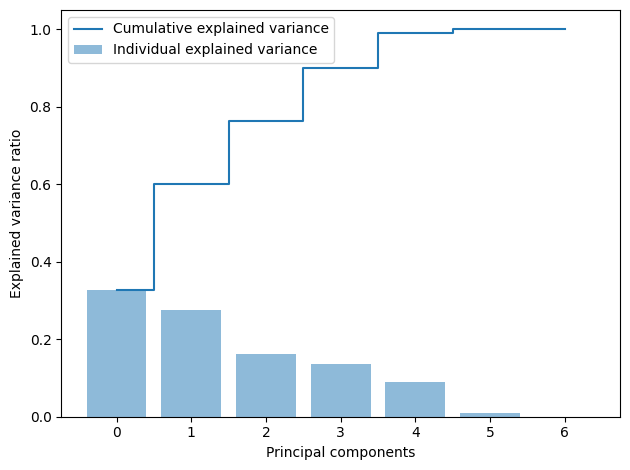

In [33]:
# instantiate PCA
pca = PCA(len(dataset_user_reduction.columns))
# determine transformed features
dataset_user_reduction = pca.fit_transform(dataset_user_reduction)

# determine explained variances and the cumulative sum
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# plot to analyze
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [34]:
# number of components to use
len(cum_sum_eigenvalues[cum_sum_eigenvalues<0.70])+1

3

**We applied the PCA with the 3 components** and even this we decided to save it as a csv file so it would be easier to reuse it

In [35]:
pca = PCA(n_components=3)
pca_fit = pca.fit_transform(dataset_user_reduction)
dataset_user_pca = pd.DataFrame(data = pca_fit, columns = ['PC1', 'PC2','PC3'])
dataset_user_pca.to_csv("dataset_user_pca.csv", index=False)

## 2.3 Clustering!

1. Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

2. Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

3. Run the algorithm on the data obtained from the dimensionality reduction.

4. Implement K-means++ from scratch and explain the differences with the results you got earlier.

5. Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

### 2.3.1

Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

**First of all as usual we load the data in order to do our clustering tasks**

In [36]:
dataset_user_for_clustering = pd.read_csv('dataset_user_pca.csv')

We have to implement the K-means algorithm and to do this we decided to use **PySpark**, after installing it in our environment using the command "pip install pyspark" we **initialised a Spark session and converted our previously created dataframe after applying PCA into a spark dataframe.** Now our Spark environment is ready and we can use it.

In [42]:
# initialization of pyspark session
findspark.init()
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "16g").config("spark.executor.memory", "12g").getOrCreate()

# creation of the spark dataset to perform the k-means algorithm
values = dataset_user_for_clustering.values.tolist()
sdf = spark.createDataFrame(values,["PC1","PC2","PC3"])

spark.sparkContext.setLogLevel("ERROR")

The **kmeans_clustering** function effectively utilizes Spark's distributed data processing capabilities to implement the K-means clustering algorithm. Through the MapReduce model:

- **Map Step**: the input DataFrame is first converted to an RDD (Resilient Distributed Dataset), which is a fundamental data structure of Spark that is distributed and fault-tolerant. The map transformation is used to convert each row of the DataFrame into a NumPy array and to distribute these arrays across the cluster for parallel processing.
The distance function, which is another map operation, computes the Euclidean distance between a data point and each centroid, assigning the data point to the nearest centroid.

- **Reduce Step** : After mapping data points to the nearest centroids, the reduceByKey operation (part of the groupByKey and mapValues) aggregates the points by their assigned centroid key and then computes the new centroids by averaging the points in each group. This is a Reduce operation because it takes the distributed data points belonging to the same centroid and combines them to produce a single output (the new centroid).

The function distributes the computation of distances and the recalculation of centroids across a cluster of machines, enabling the processing of large-scale datasets that might not fit into the memory of a single machine. The iterative nature of the algorithm ensures that it converges to a solution where data points are optimally assigned to centroids, forming the desired number of clusters. This custom implementation shows also the usage of Spark's RDD transformations and actions to perform complex data analysis tasks in a parallelized and scalable manner. manner.

In [38]:
def kmeans_clustering(dataset_for_vectorize, k, convergence_threshold=0.01):
    """
    Perform K-means clustering.

    parameter of input:
      - data: Input data as a Spark DataFrame.
      - k:    Number of clusters.
      - convergence_threshold: Threshold for convergence.
    parameter of output: Final centroids, vectorized_rdd and cluster labels.
    """
    # Convert data to RDD and vectorize
    num_partitions = 10 
    vectorized_rdd = dataset_for_vectorize.rdd.map(list).map(lambda row: np.array(row)).repartition(num_partitions)

    # Define the distance function
    def distance(x, y):
        dist = np.zeros(len(y))
        for i in range(len(y)):         
            dist[i] = np.linalg.norm(x-y[i])
        key = np.argmin(dist)
        return (key, x)

    # initialization of the centroids
    init_c = np.array(dataset_for_vectorize.limit(k).collect())
 
    # iterative process
    diff = 999
    while diff > convergence_threshold:
        d = vectorized_rdd.map(lambda row: distance(row, init_c)).repartition(num_partitions)
        updated_c = d.groupByKey().mapValues(lambda row: sum(row) / len(row)).collect()

        K_new = {}
        for i in updated_c:
            K_new[i[0]] = i[1]
        finalist = []
        for i in range(k):
            finalist.append(np.array(K_new[i]))
        final_c = np.array(finalist)

        diff = np.linalg.norm(final_c - init_c)
        init_c = final_c
        
    # cluster labels assignement
    cluster_labels_rdd = vectorized_rdd.map(lambda row: distance(row, init_c)[0])

    final_centroids = init_c
    cluster_labels = cluster_labels_rdd.collect()

    return init_c, vectorized_rdd, cluster_labels

### 2.3.2

Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

we chose to use two different methods to select the optimal clusters:
- **the elbow method**
- **the silhouette score**
We applied both methods via the sklearn library function 'KMeans' and then using the function we created.

Analysing the results obtained in the second elbow method graph, it is not very clear what the elbow point is, but based on these plots, **k=2** seems to be the optimal number of clusters for the following reasons:

- The silhouette score is maximum for **k=2** in both silhouette graphs.
- There is no clear elbow point in the other two plots, indicating that increasing the number of clusters beyond 2 does not significantly improve clustering quality.

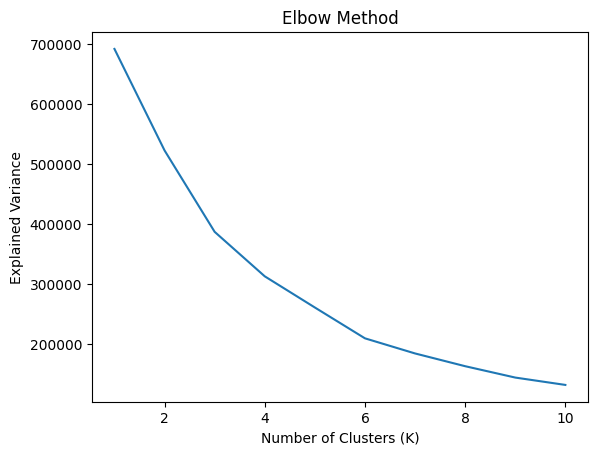

In [39]:
# elbow method using the KMeans function in sklearn

# create a list to store the explained variances
explained_variances = []

# different values of k to try
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(dataset_user_for_clustering)
    explained_variances.append(kmeans.inertia_)

# plot the explained variances - elbow method
plt.plot(k_values, explained_variances)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Explained Variance')
plt.title('Elbow Method')
plt.show()

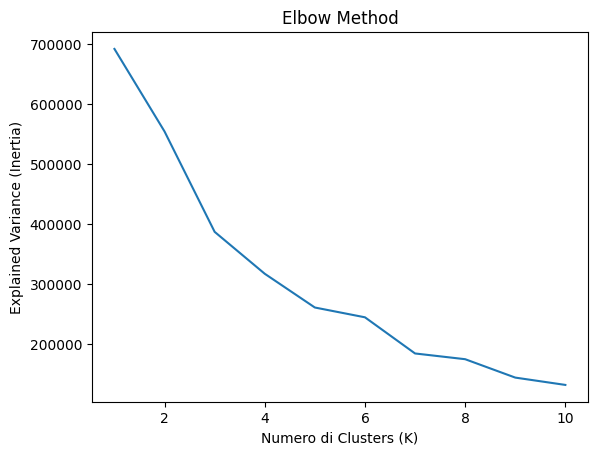

In [40]:
# elbow method using our kmeans function

# create a list to store the explained variances
explained_variances = []

# different values of k to try
k_values = range(1, 11)

# for every value of k in the range perform the k_means custom function 
for k in k_values:
    final_centroids, cluster_vectors, _ = kmeans_clustering(sdf, k)
    distances = cluster_vectors.map(lambda x: np.min(np.linalg.norm(x - final_centroids, axis=1)))
    # Calculate the explained variance as the sum of squared distances
    explained_variance = np.sum([d ** 2 for d in distances.collect()])
    explained_variances.append(explained_variance)

# plot to perform the elbow method
plt.plot(k_values, explained_variances)
plt.xlabel('Numero di Clusters (K)')
plt.ylabel('Explained Variance (Inertia)')
plt.title('Elbow Method')
plt.show()

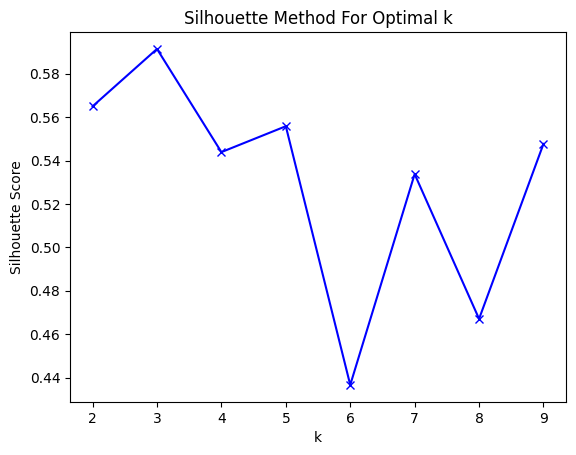

In [44]:
# silhouette score using our kmeans function

def compute_silhouette_score(centroids, rdd):
    def distance(point, centroid):
        return np.linalg.norm(point - centroid)
    
    def find_nearest_cluster(point, centroids, own_cluster):
        distances = [distance(point, centroid) for idx, centroid in enumerate(centroids) if idx != own_cluster]
        return min(distances) if distances else 0

    def compute_point_silhouette(point, centroids, cluster_index):
        own_cluster_distance = distance(point, centroids[cluster_index])
        nearest_cluster_distance = find_nearest_cluster(point, centroids, cluster_index)
        max_distance = max(own_cluster_distance, nearest_cluster_distance)
        if max_distance == 0:  # Avoid division by zero
            return 0
        silhouette = (nearest_cluster_distance - own_cluster_distance) / max_distance
        return silhouette

    # assign points to clusters
    clustered_points = rdd.map(lambda point: (np.argmin([distance(point, centroid) for centroid in centroids]), point))

    # compute silhouette score for each point
    silhouette_scores = clustered_points.map(lambda x: compute_point_silhouette(x[1], centroids, x[0]))

    # calculate the average silhouette score
    average_score = silhouette_scores.mean()
    return average_score

def silhouette_method_custom_kmeans(data, k_range):
    silhouette_values = []
    for k in k_range:
        centroids, rdd, _ = kmeans_clustering(data, k)
        silhouette_avg = compute_silhouette_score(centroids, rdd)
        silhouette_values.append(silhouette_avg)

    # plotting
    plt.plot(k_range, silhouette_values, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method For Optimal k')
    plt.show()

# usage on my spark dataset
silhouette_method_custom_kmeans(sdf, range(2, 10))


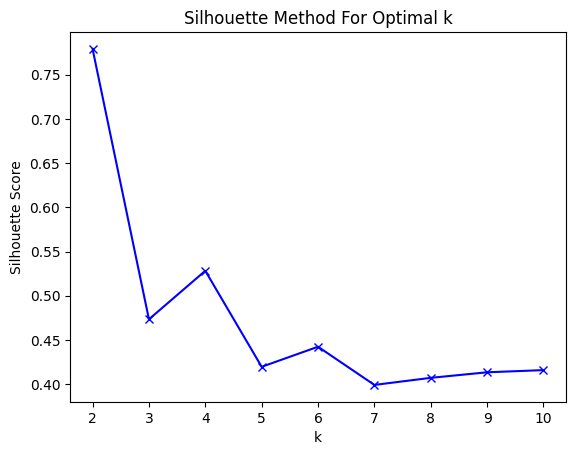

In [45]:
# silhouette score using kmeans sklearn function

# store the values
silhouette_values = []
#range for k
k_range=range(2,11)

# perform the KMeans algorithm from th esklearn library to achieve the score
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(dataset_user_for_clustering)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(dataset_user_for_clustering, labels)
    silhouette_values.append(silhouette_avg)

# plotting the variation of the silhouette score
plt.plot(k_range, silhouette_values, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

### 2.3.3

Run the algorithm on the data obtained from the dimensionality reduction.

**Now after choosing the optimal number od cluster we can compute the k-means algorithm on our dataset**

In [46]:
# optimal number of cluster obtained from the analysis done previously
k = 2

# k-means algorithm on my dataset obtained after the dimensionality reduction
final_centroids, _, _ = kmeans_clustering(sdf, k)
print(final_centroids)

[[ 0.05481644 -0.54205599 -0.12964596]
 [-0.15959062  1.57812223  0.37744657]]


### 2.3.4

Implement K-means++ from scratch and explain the differences with the results you got earlier.

The kmeans_plus_plus_clustering function is the same as the previous function with the only difference that that function begins by initializing cluster centroids using the K-means++ algorithm, which aims to select centroids that are spread out across the dataset. This is more effective than random initialization as we can see by the result as it tends to result in better clustering and faster convergence.

In [47]:
def kmeans_plusplus_init(dataset, k):
    """
    Initialize centroids using K-means++ algorithm.

    parameter of input:
    - dataset: Input data as a NumPy array.
    - k:       Number of clusters.
    parameter of output: Initial centroids as a NumPy array.
    """
    centroids = [dataset[random.randint(0, len(dataset) - 1)]]
    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in dataset])
        probabilities = distances / distances.sum()
        cumulative_probabilities = np.cumsum(probabilities)
        r = random.random()
        for i, p in enumerate(cumulative_probabilities):
            if r < p:
                centroids.append(dataset[i])
                break
    return np.array(centroids)

def kmeans_plus_plus_clustering(dataset_for_vectorize, k, convergence_threshold=0.01):
    """
    Perform K-means clustering with K-means++ initialization.

    parameter of input:
    - dataset_for_vectorize: Input data as a Spark DataFrame.
    - k:                     Number of clusters.
    - parameter of convergence_threshold: Threshold for convergence.
    parameter of output: Final centroids, vectorized RDD, cluster labels
    """
    # Convert data to RDD and vectorize
    num_partitions = 10 
    vectorized_rdd = dataset_for_vectorize.rdd.map(list).map(lambda row: np.array(row)).repartition(num_partitions)

    # Initialize centroids using K-means++
    dataset_array = np.array(vectorized_rdd.collect())  # Convert RDD to NumPy array for initialization
    init_c = kmeans_plusplus_init(dataset_array, k)

    # Define the distance function
    def distance(x, y):
        dist = np.zeros(len(y))
        for i in range(len(y)):         
            dist[i] = np.linalg.norm(x-y[i])
        key = np.argmin(dist)
        return (key, x)

    # Iterative process
    diff = 999
    while diff > convergence_threshold:
        d = vectorized_rdd.map(lambda row: distance(row, init_c)).repartition(num_partitions)
        updated_c = d.groupByKey().mapValues(lambda row: sum(row) / len(row)).collect()

        K_new = {}
        for i in updated_c:
            K_new[i[0]] = i[1]
        finalist = []
        for i in range(k):
            finalist.append(np.array(K_new[i]))
        final_c = np.array(finalist)

        diff = np.linalg.norm(final_c - init_c)
        init_c = final_c

    # Assign each point to the nearest cluster and get the cluster labels
    cluster_labels_rdd = vectorized_rdd.map(lambda row: distance(row, init_c)[0])

    # Collect the final centroids and cluster labels
    final_centroids = init_c
    cluster_labels = cluster_labels_rdd.collect()

    return final_centroids, vectorized_rdd, cluster_labels

In [48]:
# optimal number of cluster obtained from the analysis done previously
k = 2

# k-means algorithm on my dataset obtained after the dimensionality reduction
final_centroids, _ ,_ = kmeans_plus_plus_clustering(sdf, k)
print(final_centroids)

[[-1.40522730e-01 -9.09947675e-03  7.70756402e-03]
 [ 7.93167395e+00  5.13611447e-01 -4.35046236e-01]]


### 2.3.5

Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

We asked ChatGPT to recommend another clustering algorithm, he provided us with several including **DBSCAN** and **Agglomerative Hierarchical Clustering** but the former gave us problems as for our dataset there was too much noise in the cluster display and the latter gave us memory problems as it required a lot of memory to be allocated, so we chose **BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)** which we learnt was designed specifically for large datasets, which was our case, and goes to build a CF (Clustering Feature) tree for incremental clustering.
We were pleased with the results as we then calculated three different metrics to evaluate this algorithm and compared it with KMeans and noticed that they have more or less the same performance on our dataset (the analysis is above, after the algorithm). This means that the KMeans does a good job on our dataset.

143    31820
149    24843
150     7801
166     6876
218     5088
       ...  
571        1
373        1
673        1
375        1
723        1
Name: count, Length: 730, dtype: int64


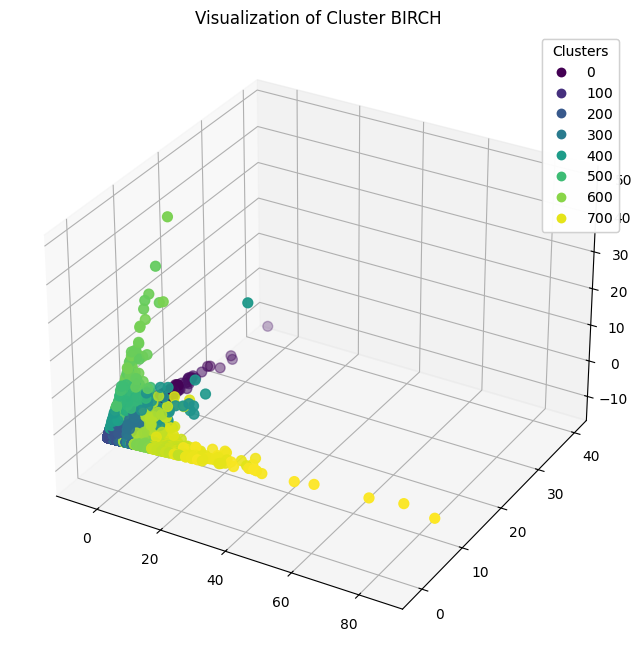

In [53]:
# Load the data
dataset_for_clustering = pd.read_csv('dataset_user_pca.csv')

# inizialitation of BIRCH
# n_clusters=None to give a BIRCH the power to determine the number of cluster
birch_model = Birch(n_clusters=None)

# clustering
birch_model.fit(dataset_for_clustering)

# cluster labels
labels = birch_model.labels_

dataset_for_clustering['cluster_labels'] = labels

# point of each cluster
cluster_counts = pd.Series(labels).value_counts()
print(cluster_counts)

# visualization of the clusters with a scatter plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(dataset_for_clustering['PC1'], dataset_for_clustering['PC2'], dataset_for_clustering['PC3'], c=dataset_for_clustering['cluster_labels'], cmap='viridis', s=50)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('Visualization of Cluster BIRCH')
plt.show()


In [54]:
# K-Means
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans_labels = kmeans.fit_predict(dataset_for_clustering)

# K-Means metrics
kmeans_silhouette = silhouette_score(dataset_for_clustering, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(dataset_for_clustering, kmeans_labels)
kmeans_davies = davies_bouldin_score(dataset_for_clustering, kmeans_labels)

# BIRCH metrics
birch_silhouette = silhouette_score(dataset_for_clustering, labels)
birch_calinski = calinski_harabasz_score(dataset_for_clustering, labels)
birch_davies = davies_bouldin_score(dataset_for_clustering, labels)

# shows the results
print("K-Means - Silhouette Score:", kmeans_silhouette)
print("K-Means - Calinski-Harabasz Score:", kmeans_calinski)
print("K-Means - Davies-Bouldin Score:", kmeans_davies)
print("\nBIRCH - Silhouette Score:", birch_silhouette)
print("BIRCH - Calinski-Harabasz Score:", birch_calinski)
print("BIRCH - Davies-Bouldin Score:", birch_davies)


K-Means - Silhouette Score: 0.8634112721497256
K-Means - Calinski-Harabasz Score: 441310.90149435954
K-Means - Davies-Bouldin Score: 0.34475676472200584

BIRCH - Silhouette Score: 0.8168316121236523
BIRCH - Calinski-Harabasz Score: 19026477.060103584
BIRCH - Davies-Bouldin Score: 0.2801737709217477


## 2.4 Analysing your results! 

You are often encouraged to explain the main characteristics that your clusters have. The latter is called the Characterizing Clusters step. Thus, follow the next steps to do it
 1. Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.
 2. Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.
 4. With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.
 5. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.
 6. Interpret the results for each pivot table.
 7. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained.results obtained., and why?

**For our analysis we choose**:
- **DURATION OF WATCHING**
- **TOTAL MOVIE**
- **DIVERSITY GENRE**

Let's have a look at table and after at the observation

In [55]:
# Load the dataset
dataset_user_clustering = pd.read_csv('dataset_user_pca.csv')

In [56]:
# K-Means custom
final_centroids, _, cluster_labels = kmeans_clustering(sdf, k=2)

# add the cluster labels to the dataframe
dataset_user_clustering['cluster'] = cluster_labels

**Load the dataset_user create after the feature engineer to do the pivot table**

In [57]:
dataset_user = pd.read_csv("dataset_user.csv")

**Definition of the functions that splits in 4 categories each of the three features selected for the pitov table**

In [58]:
def class_duration_of_watching(seconds):
    if 0 <= seconds <= 3600:  # Up to 1 hour
        return "0-1"
    elif 3601 <= seconds <= 36000:  # 1 to 10 hours
        return "1-10"
    elif 36001 <= seconds <= 108000:  # 10 to 30 hours
        return "10-30"
    else:  # More than 30 hours
        return ">30"

        
def class_total_movies(movie_count):
    if 0 <= movie_count < 3:  # Between 0 and 2
        return "0-2"
    elif 3 <= movie_count < 6:  # Between 3 and 5
        return "2-5"
    elif 6 <= movie_count < 11:  # Between 6 and 10
        return "5-10"
    else:  # More than 10
        return ">10"

    
def class_diversity_genre(different_genre_count):
    if 0 <= different_genre_count < 2:  # Between 0 and 1
        return "0-1"
    elif 2 <= different_genre_count < 4:  # Between 2 and 3
        return "1-3"
    elif 4 <= different_genre_count < 6:  # Between 4 and 5
        return "3-5"
    else:  # More than 5
        return ">5"


**Using the function above we apply it for each row in the dataset corrisponding to the feature selected**

In [59]:
dataset_user["cluster"] = dataset_user_clustering["cluster"]
dataset_user["duration_of_watching_class"] = dataset_user.duration_average.apply(lambda row: class_duration_of_watching(row))
dataset_user["total_movies_class"] = dataset_user.total_movies_watched.apply(lambda row: class_total_movies(row))
dataset_user["diversity_genre_class"] = dataset_user.genre_diversity_count.apply(lambda row: class_diversity_genre(row))

**Now we are ready to do the pivot table with the information above normalizing as request**

In [60]:
pivot_table_1 = round(pd.crosstab(index=dataset_user.cluster, columns=dataset_user.duration_of_watching_class, values=dataset_user.duration_average, aggfunc="count", normalize="index")*100,1)
pivot_table_2 = round(pd.crosstab(index=dataset_user.cluster, columns=dataset_user.total_movies_class, values=dataset_user.total_movies_watched, aggfunc="count", normalize="index")*100,1)
pivot_table_3 = round(pd.crosstab(index=dataset_user.cluster, columns=dataset_user.diversity_genre_class, values=dataset_user.genre_diversity_count, aggfunc="count", normalize="index")*100,1)

**FIRST PIVOT TABLE: duration_of_watching**

In [61]:
pivot_table_1

duration_of_watching_class,0-1,1-10,10-30,>30
cluster,,,,
0,50.4,28.1,12.2,9.3
1,50.5,28.0,12.2,9.2


**SECOND PIVOT TABLE: total_movies**

In [62]:
pivot_table_2

total_movies_class,0-2,2-5,5-10,>10
cluster,,,,
0,65.1,21.8,8.9,4.3
1,65.0,21.7,8.9,4.3


**THIRD PIVOT TABLE: diversity of genre**

In [63]:
pivot_table_3

diversity_genre_class,0-1,1-3,3-5,>5
cluster,,,,
0,6.7,38.3,43.6,11.4
1,6.7,38.4,43.6,11.4


### OBSERVATION AND INTERPRETATION:

For our pivot table we choose these 3 features:
- **Duration of Watching Class**: This category represent the time users spend watching content, classified into four ranges: 0-1 hours, 1-10 hours, 10-30 hours, and more than 30 hours. The distribution is quite similar across the clusters, because the majority of users (about 50%) in all clusters watch content for 0-1 hour, the next largest group (around 28%) watches between 1 and 10 hours and only smaller percentages of users watch for longer durations, with slightly decreasing percentages as the watching time increases.
- **Total Movies Class**: This category represents the number of movies watched by users, segmented into four ranges: 0-2, 2-5, 5-10, and more than 10 movies. Again, the distribution is fairly consistent across clusters, because most users (about 65%) watch between 0 and 2 movies, making it the most common behavior, around 21% to 22% of users watch between 2 and 5 movies and fewer users watch a larger number of movies, with very small percentages (4% to 5%) watching more than 10 movies.
- **Diversity Genre Class**: This category likely indicates the count of different genres of movies watched by users, categorized into four groups: 0-1, 1-3, 3-5, and more than 5 genres. The clusters show slight variations, a small fraction of users (around 6%) stick to 0-1 genres, a significant proportion of users watch movies in 1-3 genres (about 38% to 39%) and 3-5 genres (about 43% to 45%) and a modest percentage of users (about 10% to 11%) have a diverse watching habit that spans more than 5 genres.

The pivot tables suggest that the user base can be characterized by relatively homogeneous watching habits in terms of duration, the total number of movies watched, and genre diversity. The clusters don't show drastic differences in these aspects, indicating that while users have been segmented into distinct clusters, their behaviors within these categories are quite similar. From a clustering perspective, this could imply that the clustering algorithm has found more nuanced differences between users that may not be captured fully in these categories. Alternatively, it could mean that these particular features do not provide a strong basis for differentiation between clusters.

The results we've obtained from the silhouette_score and calinski_harabasz_score metrics for both the sklearn's KMeans and your custom KMeans implementation show significant differences. Let's analyze these scores both individually and comparatively.

- **Silhouette Score:**

**Sklearn KMeans: 0.7637**

**Custom KMeans: 0.1719**

The silhouette score ranges from -1 to 1. A high silhouette score indicates that the clusters are well-separated and distinct, with data points in each cluster being closer to each other than to points in other clusters. A score closer to 1 is considered good. Sklearn KMeans has a high silhouette score, suggesting good cluster separation and tight clustering. Custom KMeans has a much lower score, indicating that the clusters are not as well-defined and that there might be considerable overlap or the points are not as closely clustered.

- **Calinski-Harabasz Score:**
  
**Sklearn KMeans: 46369.15**

**Custom KMeans: 6287.66**

The Calinski-Harabasz score, also known as the Variance Ratio Criterion, is higher when the clusters are dense and well-separated, which relates to a model with better-defined clusters. There's no upper limit for this score, but a higher value generally indicates better clustering. Sklearn KMeans shows a very high Calinski-Harabasz score, suggesting that the clusters have low intra-cluster variance and high inter-cluster variance, which is desirable. Custom KMeans has a considerably lower score, indicating that the clusters might not be as well-separated and could have higher intra-cluster variance.

**Let's compare the result:**

Sklearn KMeans outperforms the Custom KMeans significantly in both metrics. This suggests that the sklearn implementation of KMeans is resulting in much better clustering for your dataset. The low scores of the Custom KMeans might be due to various factors like the choice of initial centroids, the algorithm used for centroid updating, or other implementation details that differ from the sklearn version.

In conclusion, we can say that the clustering results appear to be moderately satisfactory, the data points within each cluster are more similar to each other than to points in other clusters, but we can surely improve performance.

chieve similar performance.

In [68]:
# Labels extract with the KMeans from Sklearn library
labels = KMeans(n_clusters=2, n_init=10).fit(dataset_user_clustering).labels_

# calculate scores
silhouette_sc = silhouette_score(dataset_user_clustering, labels)
calinski_harabasz_sc = calinski_harabasz_score(dataset_user_clustering, labels)

#showing the results
print("Sklearn K-Means - Silhouette Score:", silhouette_sc)
print("Sklearn K-Means - Calinsky Harabasz:", calinski_harabasz_sc)


Sklearn K-Means - Silhouette Score: 0.7637291255329192
Sklearn K-Means - Calinsky Harabasz: 46369.152127238034


In [71]:
# Our custon KMeans algorithm
_,_, cluster_labels = kmeans_clustering(sdf, k=2)

# scores using our custom KMeans
silhouette_sc_1 = silhouette_score(dataset_user_clustering, cluster_labels)
calinski_harabasz_sc_1 = calinski_harabasz_score(dataset_user_clustering, cluster_labels)

# showing the results
print("Custom K-Means - Silhouette Score:", silhouette_sc_1)
print("Custom K-Means - Calinsky Harabasz: Score", calinski_harabasz_sc_1)

Custom K-Means - Silhouette Score: 0.17194013402895458
Custom K-Means - Calinsky Harabasz: Score 6287.661822990281
